# Homework 1: Interstellar Medium

 Osmer Alexander Suárez López

## 1. (12 points) Analysis of interstellar gas components using Gaussian decomposition

This problem analyses the properties of a neutral hydrogen (HI) cloud in the Small Magellanic Cloud (SMC). The data was taken with the ASKAP telescope and is a subset of the data presented in Pingel et al. 2022 (https://doi.org/10.1017/pasa.2021.59).

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import os
%matplotlib inline
import matplotlib
from pylab import cm



import pandas as pd
from astropy.io import ascii
from spectral_cube import SpectralCube
from scipy.stats import lognorm, norm
from reproject import reproject_interp
import matplotlib as mpl


from gausspyplus.plotting import get_points_for_colormap, shiftedColorMap

from astropy.modeling import models, fitting
from astropy.modeling.models import Gaussian1D

In [50]:
# opening the data file

data_dir = '/home/osmer/objetos_astrofisicos/'
file = 'cloud_sub_cube.fits'
hdul = fits.open(data_dir+file)

# Fits files have a header part, which contains the metadata of the file, in this case the details of the observation
h = hdul[0].header

#data part, which is esentially an N dimensional matrix with numbers
d = hdul[0].data

#Obtain the dimensions
print("The dimensions of the data cube are:",d.shape)

The dimensions of the data cube are: (220, 180, 180)


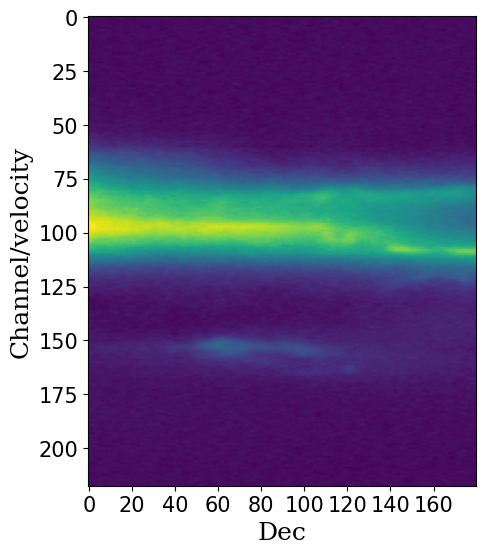

In [3]:
fig = plt.figure(figsize=(11,8))

d_2_av2 = np.mean(d, axis=2)

ax = fig.add_subplot(1,2,1)
plt.imshow(d_2_av2[:-2,:])

ax.set_xlabel('Dec', size=18,family='serif')
ax.set_ylabel('Channel/velocity', size=18,family='serif')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

In the plot we can find two disticnt features, the big one that is around 75-125 in the chanel/velocity axis and the other one around 150.

In [6]:
d_av = np.sum(d[:,:,:], axis = 1)
#print(d_av.shape)
d_av_3 = np.sum(d_av[:,:], axis = 1)
spectra = d_av_3[:-3]

In [7]:
# checking the units of the spectral axis
print('3rd axis type', h['CTYPE3'])  # the third dimension of this cube is in heliocentric velocity
print('3rd axis steps', h['CDELT3']) # in m/s
print('3rd axis reference', h['CRVAL3']) # in m/s
print('data units', h['BUNIT'])

3rd axis type VRAD
3rd axis steps -977.198303423
3rd axis reference 257847.381515
data units K


In [8]:
# calculate the value for the first coordinate
s_start = h['CRVAL3'] - h['CRPIX3']*h['CDELT3']

# calculate the velocity axis
x_axis = (np.arange(0,len(spectra))*h['CDELT3']+s_start) / 1000 # we also convert to km/s from m/s

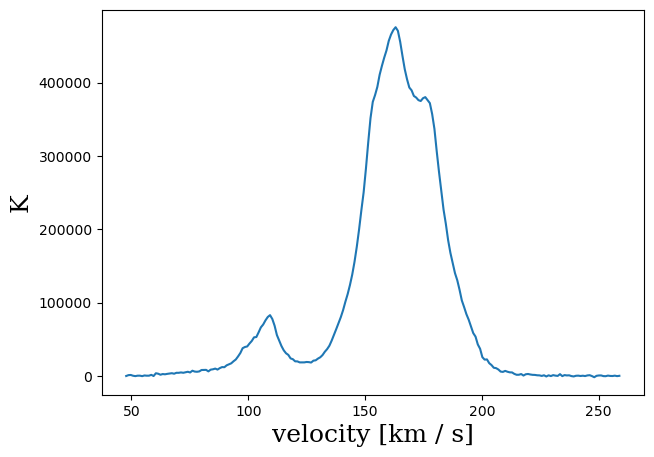

In [9]:
# make figure

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)
s=plt.plot(x_axis, spectra)

ax.set_xlabel('velocity [km / s]', size=18,family='serif')
ax.set_ylabel('K', size=18,family='serif')

plt.show()




The intensity seems to be different with the first plot, because for the value of 100 in chanel/velocity we have a greater intensity, however in the plot above we notice that the major of the intensity is around 160 km/s

In [10]:
#Getting the indices for velocities between 96-113 km/s
b = np.where((96 <= x_axis) & (x_axis<=113))
print(b)

(array([150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
       163, 164, 165, 166]),)


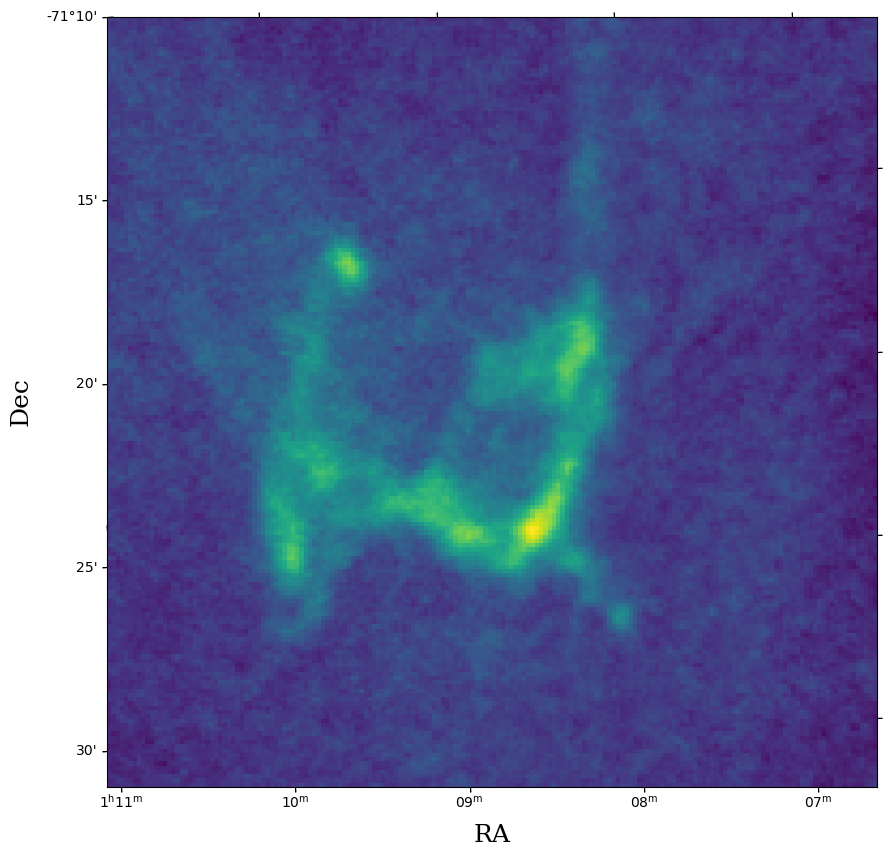

In [11]:
#Taking the array for the range of the desired velocities
d_vel = d[150:167,:,:]

fig = plt.figure(figsize=(11,10))

# moment 0 - integrated intensity per pixel
d_2_av = np.sum(d_vel, axis=0)* abs(h['CDELT3'])/1000

ax = fig.add_subplot(1,1,1, projection=WCS(h), slices=('x', 'y', 50))
plt.imshow(d_2_av)
ax.set_xlabel('RA', size=18,family='serif')
ax.set_ylabel('Dec', size=18,family='serif')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

What kind of structure do you see?

It seems to be a molecular cloud.

In [2]:
def get_cmap_rchi2(vmin, vmax):
    orig_cmap = matplotlib.cm.RdBu_r
    start, stop = get_points_for_colormap(vmin, vmax, central_val=1.)
    midpoint = (1 - vmin) / (vmax - vmin)
    return shiftedColorMap(orig_cmap, start=0., midpoint=midpoint, stop=stop)


def add_style(ax):
    ax.set_xlabel('Galactic Longitude')
    ax.set_ylabel('Galactic Latitude')


if not os.path.exists('decomposition_grs'):
    !mkdir decomposition_grs

In [3]:
#creating a configuration file
import gausspyplus.config_file as cf
cf.make()

SAVED FILE: 'gausspy+.ini' in '/home/osmer/objetos_astrofisicos'


In [55]:
#preparing the data 
#change the script in order to get the real path
!python step_3-prepare--grs.py




calculating average rms from data...
100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 3053.47it/s]
>> calculated rms value of 1.346 from data

GaussPy preparation

preparing GaussPy cube...
Using 3 of 4 cpus
100%|█████████████████████████████████████| 32.4k/32.4k [00:13<00:00, 2.44kit/s]
32397it [00:00, 651475.79it/s]
SUCCESS

32400it [00:00, 345318.98it/s]

pickle dump dictionary...
For GaussPyDecompose: 'path_to_pickle_file' = 'decomposition_grs/gpy_prepared/cloud_sub_cube.pickle'

SAVED FILE: 'cloud_sub_cube_noise_map.fits' in 'decomposition_grs/gpy_maps'

Plotting...






100%|███████████████████████████████████████████| 25/25 [00:02<00:00, 11.32it/s]

SAVED FILE: 'grs-test_field_plots.pdf' in 'decomposition_grs/gpy_plots'


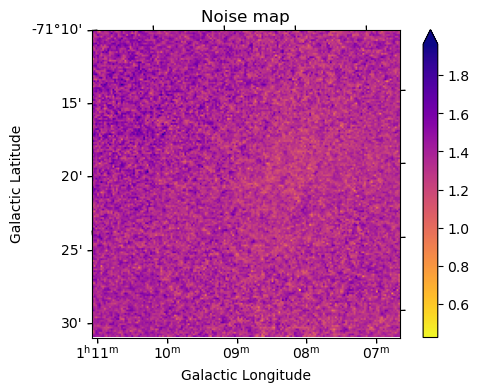

In [5]:
filepath = os.path.join('decomposition_grs', 'gpy_maps', 'cloud_sub_cube_noise_map.fits')
noise = fits.getdata(filepath)
wcs = WCS(fits.getheader(filepath))
n_min = np.min(noise)
n_max = np.max(noise)
fig, ax = plt.subplots(figsize=(6, 4), subplot_kw=dict(projection=wcs))

img_noise = ax.imshow(noise, cmap='plasma_r', vmin=n_min, vmax=n_max)
fig.colorbar(img_noise, ax=ax, extend='max')
ax.set_title('Noise map')
add_style(ax)

plt.show()

In [15]:
#  run the script
!python step_4-decompose--grs.py




pickle load 'cloud_sub_cube.pickle'...

GaussPy decomposition

decomposition settings:
GaussPy:
Two phase decomposition: True
alpha1: 1.59
alpha2: 5.9
SNR1: 3.0
SNR2: 3.0

improve_fitting: True
min_fwhm: 1.0
max_fwhm: None
snr: 3.0
snr_fit: 1.5
significance: 5.0
snr_negative: 3.0
rchi2_limit: None
max_amp_factor: 1.1
neg_res_peak: True
broad: True
blended: True
fwhm_factor: 2.0
separation_factor: 0.8493218
exclude_means_outside_channel_range: True
min_pvalue: 0.01
max_ncomps: None

decomposing data...
using 3 out of 4 cpus
100%|██████████████████████████████████████| 32.4k/32.4k [36:01<00:00, 15.0it/s]
32399it [00:00, 511065.35it/s]

pickle dump GaussPy final results...
SAVED FILE: 'cloud_sub_cube_g+_fit_fin.pickle' in 'decomposition_grs/gpy_decomposed'

making component map...
SAVED FILE: 'cloud_sub_cube_g+_component_map.fits' in 'decomposition_grs/gpy_maps'

making reduced chi2 map...
SAVED FILE: 'cloud_sub_cube_g+_rchi2_map.fits' in 'decomposition_grs/gpy_maps'

Plotting...
100%|

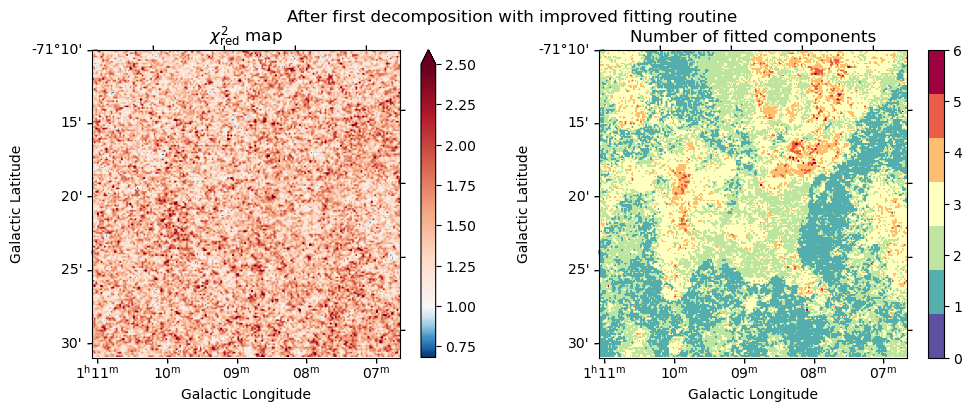

In [19]:
%matplotlib inline
filepath = os.path.join('decomposition_grs', 'gpy_maps', 'cloud_sub_cube_g+_rchi2_map.fits')
rchi2 = fits.getdata(filepath)
wcs = WCS(fits.getheader(filepath))

fig, axes = plt.subplots(ncols=2, figsize=(12, 4), subplot_kw=dict(projection=wcs))

ax = axes.flatten()[0]

vmin = min(rchi2.flatten())
vmax = 2.5
new_cmap = get_cmap_rchi2(vmin, vmax)

img_rchi2 = ax.imshow(rchi2, cmap=new_cmap, vmin=vmin, vmax=vmax)
fig.colorbar(img_rchi2, ax=ax, extend='max')
ax.set_title('$\chi_{\mathrm{red}}^{2}$ map')
add_style(ax)

ax = axes.flatten()[1]

ncomps = fits.getdata(os.path.join(
    'decomposition_grs', 'gpy_maps', 'cloud_sub_cube_g+_component_map.fits'))

vmax = 6
new_cmap = cm.get_cmap('Spectral_r', vmax + 1)

img_ncomps = ax.imshow(ncomps, cmap=new_cmap, vmin=0, vmax=vmax)
fig.colorbar(img_ncomps, ax=ax)
ax.set_title('Number of fitted components')
add_style(ax)

fig.suptitle('After first decomposition with improved fitting routine')

plt.show()

In [6]:
#Spatially coherent refitting - phase 1
#  run the script
!python step_5-spatial_refitting-p1--grs.py


Spatial refitting - Phase 1

Flagging:
 - Blended components: True
 - Negative residual features: True
 - Broad components: True
   flagged if FWHM of broadest component in spectrum is:
   >= 2.0 times the FWHM of second broadest component
   or
   >= 2.0 times any FWHM in >= 50% of its neigbors
 - High reduced chi2 values (> None): False
 - Non-Gaussian distributed residuals: True
 - Differing number of components: True

For phase 1:
Exclude flagged spectra as possible refit solutions in first refit attempts: False
Use also flagged spectra as refit solutions in case no new best fit could be obtained from unflagged spectra: False

Refitting:
 - Blended components: True
 - Negative residual features: True
 - Broad components: True
   try to refit if FWHM of broadest component in spectrum is:
   >= 2.0 times the FWHM of second broadest component
   or
   >= 2.0 times any FWHM in >= 50% of its neigbors
 - High reduced chi2 values (> None): False
 - Non-Gaussian distributed residuals: Fal

100%|███████████████████████████████████████| 9.32k/9.32k [00:14<00:00, 651it/s]
9322it [00:00, 397791.27it/s]
SUCCESS

Results of the refit iteration:
Tried to refit 18 spectra
Successfully refitted 11 spectra (61.11%)

***

determine spectra that need refitting...

9319 out of 32400 spectra (28.76%) selected for refitting:
 - 3916 spectra w/ blended components (3916 flagged)
 - 175 spectra w/ negative residual feature (175 flagged)
 - 7156 spectra w/ broad feature (7156 flagged)
   (info: 187 spectra w/ a FWHM > 73 channels)
 - 0 spectra w/ high rchi2 value (0 flagged)
 - 0 spectra w/ residual not passing normality test (3922 flagged)
 - 176 spectra w/ differing number of components (176 flagged)

start refit iteration #11...
Using 3 of 4 cpus
100%|███████████████████████████████████████| 9.32k/9.32k [00:14<00:00, 641it/s]
9316it [00:00, 341745.33it/s]
SUCCESS

Results of the refit iteration:
Tried to refit 11 spectra
Successfully refitted 6 spectra (54.55%)

***

determine spectra t

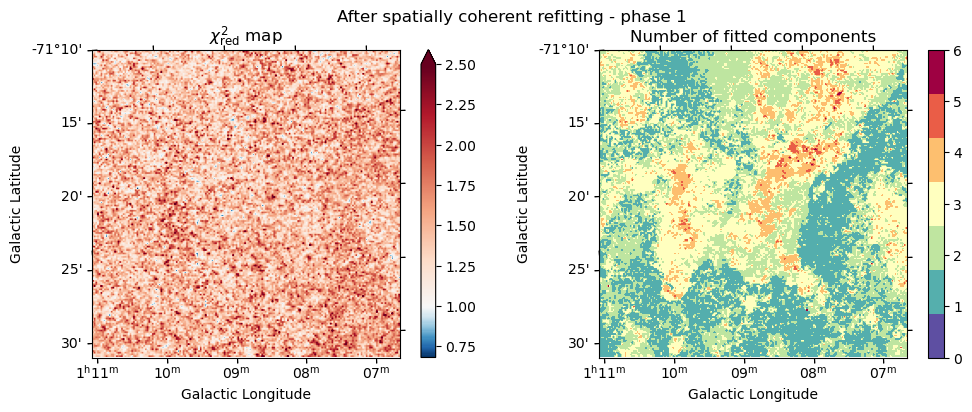

In [7]:
filepath = os.path.join(
    'decomposition_grs', 'gpy_maps', 'cloud_sub_cube_g+_fit_fin_sf-p1_rchi2_map.fits')
rchi2 = fits.getdata(filepath)
header = fits.getheader(filepath)
wcs = WCS(header)

fig, axes = plt.subplots(ncols=2, figsize=(12, 4), subplot_kw=dict(projection=wcs))

ax = axes.flatten()[0]

vmin = min(rchi2.flatten())
vmax = 2.5
new_cmap = get_cmap_rchi2(vmin, vmax)

img_rchi2 = ax.imshow(rchi2, cmap=new_cmap, vmin=vmin, vmax=vmax)
fig.colorbar(img_rchi2, ax=ax, extend='max')
ax.set_title('$\chi_{\mathrm{red}}^{2}$ map')
add_style(ax)

ax = axes.flatten()[1]

ncomps = fits.getdata(os.path.join(
    'decomposition_grs', 'gpy_maps', 'cloud_sub_cube_g+_fit_fin_sf-p1_component_map.fits'))

vmax = 6
new_cmap = cm.get_cmap('Spectral_r', vmax + 1)

img_ncomps = ax.imshow(ncomps, cmap=new_cmap, vmin=0, vmax=vmax)
fig.colorbar(img_ncomps, ax=ax)
ax.set_title('Number of fitted components')
add_style(ax)

fig.suptitle('After spatially coherent refitting - phase 1')

plt.show()

In [4]:
#Spatially coherent refitting - phase 2
#  run the script
!python step_6-spatial_refitting-p2--grs.py


Spatial refitting - Phase 2

Flagging:
 - Blended components: True
 - Negative residual features: True
 - Broad components: True
   flagged if FWHM of broadest component in spectrum is:
   >= 2.0 times the FWHM of second broadest component
   or
   >= 2.0 times any FWHM in >= 50% of its neigbors
 - High reduced chi2 values (> None): False
 - Non-Gaussian distributed residuals: True
 - Differing number of components: True

threshold for required components: 0.833

 Flags:
 - 3911 spectra w/ blended components
 - 175 spectra w/ negative residual feature
 - 7149 spectra w/ broad feature
   (info: 187 spectra w/ a FWHM > 73 channels)
 - 0 spectra w/ high rchi2 value
 - 3921 spectra w/ residual not passing normality test
 - 176 spectra w/ differing number of components

check which spectra require refitting...

determine neighbors for all spectra...
32400it [00:18, 1759.95it/s]

start refit iteration #1...
Using 3 of 4 cpus
100%|██████████████████████████████████████| 32.4k/32.4k [33:30<00


start refit iteration #12...
Using 3 of 4 cpus
100%|████████████████████████████████████| 9.19k/9.19k [2:06:06<00:00, 1.21it/s]
9190it [00:00, 389720.08it/s]
SUCCESS

Results of the refit iteration:
Tried to refit 717 spectra
Successfully refitted 280 spectra (39.05%)

***

threshold for required components: 0.667

 Flags:
 - 4840 spectra w/ blended components
 - 169 spectra w/ negative residual feature
 - 8132 spectra w/ broad feature
   (info: 245 spectra w/ a FWHM > 73 channels)
 - 0 spectra w/ high rchi2 value
 - 3686 spectra w/ residual not passing normality test
 - 221 spectra w/ differing number of components

check which spectra require refitting...

start refit iteration #13...
Using 3 of 4 cpus
100%|██████████████████████████████████████| 3.48k/3.48k [01:41<00:00, 34.1it/s]
3477it [00:00, 403653.44it/s]
SUCCESS

Results of the refit iteration:
Tried to refit 324 spectra
Successfully refitted 143 spectra (44.14%)

***

threshold for required components: 0.667

 Flags:
 - 4852

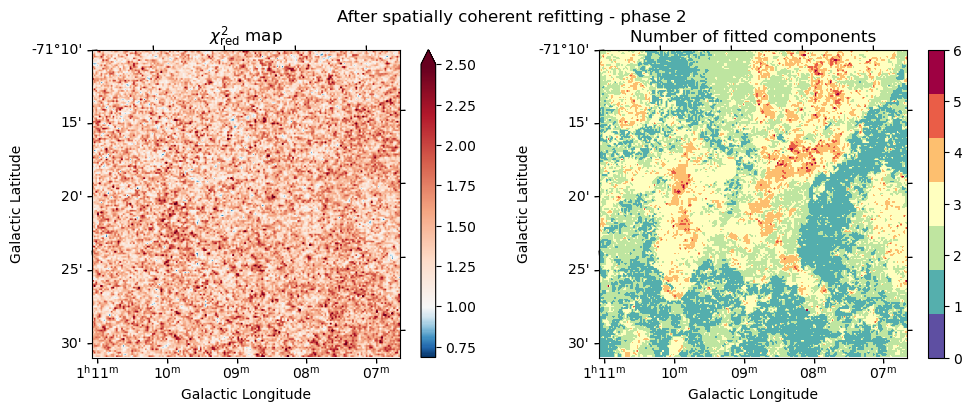

In [6]:
filepath = os.path.join(
    'decomposition_grs', 'gpy_maps', 'cloud_sub_cube_g+_fit_fin_sf-p2_rchi2_map.fits')
rchi2 = fits.getdata(filepath)
wcs = WCS(fits.getheader(filepath))

fig, axes = plt.subplots(ncols=2, figsize=(12, 4), subplot_kw=dict(projection=wcs))

ax = axes.flatten()[0]

vmin = min(rchi2.flatten())
vmax = 2.5
new_cmap = get_cmap_rchi2(vmin, vmax)

img_rchi2 = ax.imshow(rchi2, cmap=new_cmap, vmin=vmin, vmax=vmax)
fig.colorbar(img_rchi2, ax=ax, extend='max')
ax.set_title('$\chi_{\mathrm{red}}^{2}$ map')
add_style(ax)

ax = axes.flatten()[1]

ncomps = fits.getdata(os.path.join(
    'decomposition_grs', 'gpy_maps', 'cloud_sub_cube_g+_fit_fin_sf-p2_component_map.fits'))

vmax = 6
new_cmap = cm.get_cmap('Spectral_r', vmax + 1)

img_ncomps = ax.imshow(ncomps, cmap=new_cmap, vmin=0, vmax=vmax)
fig.colorbar(img_ncomps, ax=ax)
ax.set_title('Number of fitted components')
add_style(ax)

fig.suptitle('After spatially coherent refitting - phase 2')

plt.show()

Based on the map, did the decomposition perform well? How many components did Gausspy find on average?

We can say that the $\chi_{red}^2$ has not suffer a significant change during the decomposition, however, the map shows more spatial coherence with respect of the image of the molecular cloud. The number of fitted components was 6.

In [10]:
# Finally run the script
!python step_7-finalize--grs.py


check which spectra require refitting...

determine neighbors for all spectra...
32400it [00:19, 1659.40it/s]

start refit iteration #1...
Using 3 of 4 cpus
100%|███████████████████████████████████████| 32.4k/32.4k [00:38<00:00, 845it/s]
32397it [00:00, 495620.80it/s]
SUCCESS
Using 3 of 4 cpus
100%|█████████████████████████████████████| 32.4k/32.4k [00:11<00:00, 2.80kit/s]
32397it [00:00, 451484.59it/s]
SAVED FILE: 'cloud_sub_cube_g+_fit_fin_sf-p2_finalized.dat' in 'decomposition_grs/gpy_decomposed'


In [11]:
# read the data file

data_dir = '/home/osmer/objetos_astrofisicos/decomposition_grs/gpy_decomposed/'
data_file = 'cloud_sub_cube_g+_fit_fin_sf-p2_finalized.dat'
data = ascii.read(os.path.join(data_dir + data_file))

In [38]:
data.keys()

['x_pos',
 'y_pos',
 'RA',
 'DEC',
 'amp',
 'e_amp',
 'VLSR',
 'e_VLSR',
 'vel_disp',
 'e_vel_disp',
 'int_tot',
 'e_int_tot',
 'rms',
 'pvalue',
 'aicc',
 'rchi2',
 'ncomps',
 'ncomp_wmedian',
 'ncomp_jumps',
 'flag_blended',
 'flag_neg_res_peak',
 'flag_broad',
 'flag_centroid']

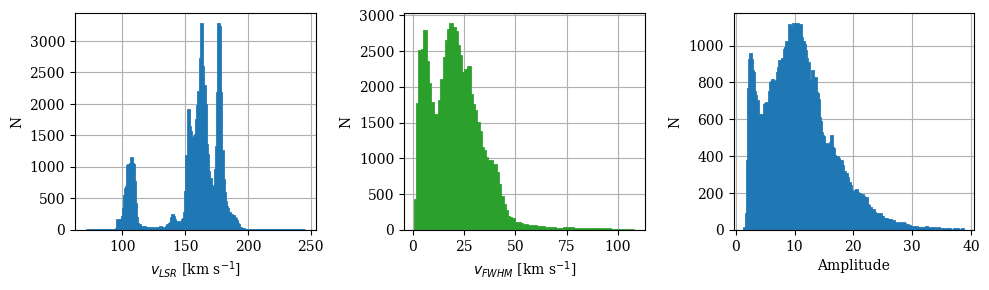

In [36]:
fig = plt.figure(figsize=(10, 3))
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])

# plot velocity distributio of the components
# this indicates the emission at different velocities -> motion of the gas + different clouds in the line of sight

ax1 = fig.add_subplot(1, 3, 1)
d1 = data['VLSR']
plt.hist(d1, bins=200, histtype='step', color='C0', fill=True, linewidth=2)
plt.xticks(family='serif', size=10)
plt.yticks(family='serif', size=10)
ax1.set_xlabel(r'$v_{LSR}$ [km s$^{-1}$]', size=10, family='serif')
ax1.set_ylabel('N', size=10, family='serif')
plt.grid(True)

# FWH plots
ax2 = fig.add_subplot(1, 3, 2)  

#convert sigma to FWHM:
d2 = abs(data['vel_disp']) * 2.355
plt.hist(d2, bins=100, histtype='step', color='C2', fill=True, linewidth=2)
plt.xticks(family='serif', size=10)
plt.yticks(family='serif', size=10)
ax2.set_xlabel(r'$v_{FWHM}$ [km s$^{-1}$]', size=10, family='serif')
ax2.set_ylabel('N', size=10, family='serif')
plt.grid(True)

#amplitude
ax3 = fig.add_subplot(1, 3, 3)
d3 = data['amp']
plt.hist(d3, bins=200, histtype='step', color='C0', fill=True, linewidth=2)
plt.xticks(family='serif', size=10)
plt.yticks(family='serif', size=10)
ax3.set_xlabel(r'Amplitude', size=10, family='serif')
ax3.set_ylabel('N', size=10, family='serif')
plt.grid(True)

plt.tight_layout()
plt.show()

What can you conclude about the structure of the interstellar gas based on the histograms?

First we could say that the interstellar gas has velocities LSR around 100$km s^{-1}$ and also in a range of around 150-180$km s^{-1}$ with few velocities for 170 $km s^{-1}$ approximately, that is to say, the gas has some zones with higher velocities, it could be due to a concentration of the gas in some specific regions. The second histogram, shows us that the range of the velocity FWHM is 0-40$km s^{-1}$ approximately, this says that for velocities higher than 50$km s^{-1}$ the signal is reduced, it could contain some dust. Finally, the third histograms show us that the amplitude range goes from 0-15 approximately.


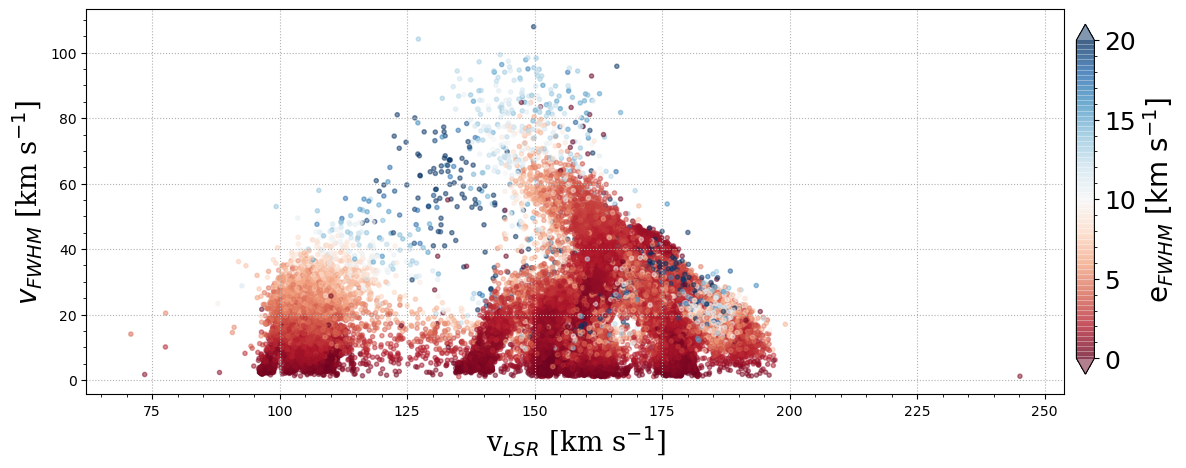

In [39]:
# velocity vs. FWHM

fig = plt.figure(figsize=(12.,5.))
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])
#plt.title('SiO')

ax = fig.add_subplot(1,1,1)
cb = plt.scatter(data['VLSR'], abs(data['vel_disp']*2.355), marker='.', c=abs(data['e_vel_disp']*2.355), cmap='RdBu', alpha=0.5, vmax=20)
ax.set_xlabel('v$_{LSR}$ [km s$^{-1}$]', size=20,family='serif')
ax.set_ylabel(r'$v_{FWHM}$ [km s$^{-1}$]', size=20,family='serif')



ax.minorticks_on()
plt.grid(True, linestyle=':')

fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.15, 0.015, 0.7])
cbar =fig.colorbar(cb, cax=cbar_ax, extend='both')
cbar.minorticks_on()
cbar.ax.tick_params(labelsize=18) 
cbar.ax.set_ylabel('e$_{FWHM}$ [km s$^{-1}$]', fontsize=20)
plt.show()

How many distinct features do you see?

We can appreciate two distinct features on a red scale.

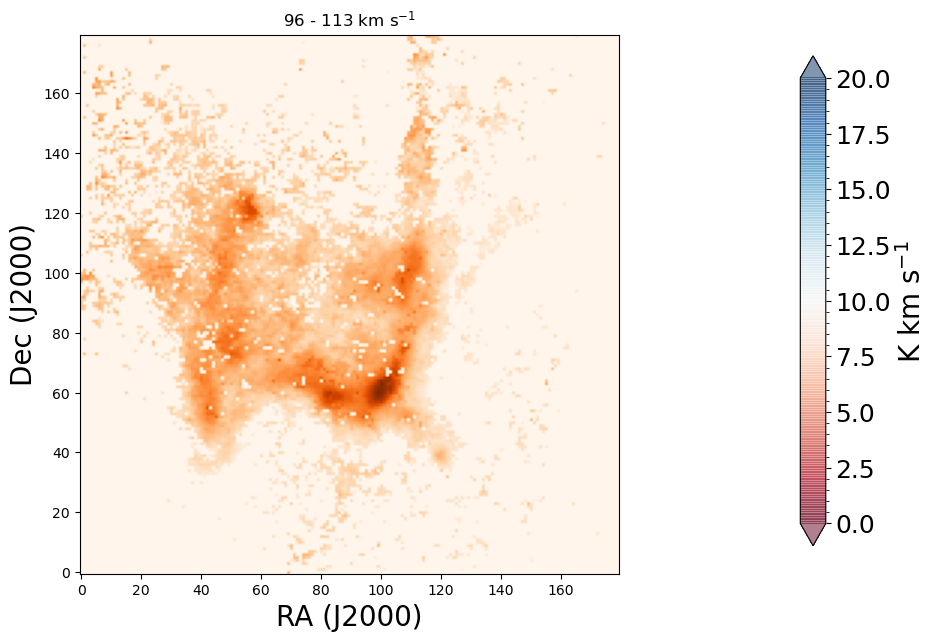

In [49]:
# divide the data into 2 sections:
data_2 = data[abs(data['VLSR'])>(96)] 
data_2 = data[abs(data['VLSR'])<(113)] 


# exclude flagged pixels:
data_2 = data_2[abs(data_2['flag_neg_res_peak'])==0] 
data_2 = data_2[abs(data_2['ncomp_jumps'])==0] 
data_2 = data_2[abs(data_2['ncomp_jumps'])==0] 


# make the plot with the intensities
# first create the grid for the image
x = np.arange(np.max(data['x_pos'])+1)
y = np.arange(np.max(data['y_pos'])+1)
xx, yy = np.meshgrid(x, y, sparse=True)

z_2 = xx + yy
z_2 = z_2*0



for i in range(len(data_2)):
    k = data_2[i]['y_pos']
    l = data_2[i]['x_pos']
    z_2[k][l] = z_2[k][l] + abs(data_2[i]['int_tot'])



# plot the image
fig = plt.figure(figsize=(17.,7))

ax1 = fig.add_subplot(1,2,1)
plt.title(r'96 - 113 km s$^{-1}$')
plt.imshow(z_2, cmap='Oranges')
ax1.set_xlabel("RA (J2000)", fontsize=20)
ax1.set_ylabel("Dec (J2000)", fontsize=20)
ax1.invert_yaxis()

#plt.colorbar() 
fig.subplots_adjust(right=2.5)
cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])
cbar =fig.colorbar(cb, cax=cbar_ax, extend='both')
cbar.minorticks_on()
cbar.ax.tick_params(labelsize=18) 
cbar.ax.set_ylabel('K km s$^{-1}$', fontsize=20)

fig.show()

In [54]:
#pixels x: 110, y:100
x_pix1 = 110
y_pix1 = 100

data_21 = data[data['x_pos']==x_pix1]
data_31 = data_21[data_21['y_pos']==y_pix1]


#pixels x:55, y:50
x_pix2 = 55
y_pix2 = 50

data_22 = data[data['x_pos']==x_pix2]
data_32 = data_22[data_22['y_pos']==y_pix2]


#pixels x:160, y:160
x_pix3 = 160
y_pix3 = 160

data_23 = data[data['x_pos']==x_pix3]
data_33 = data_23[data_23['y_pos']==y_pix3]


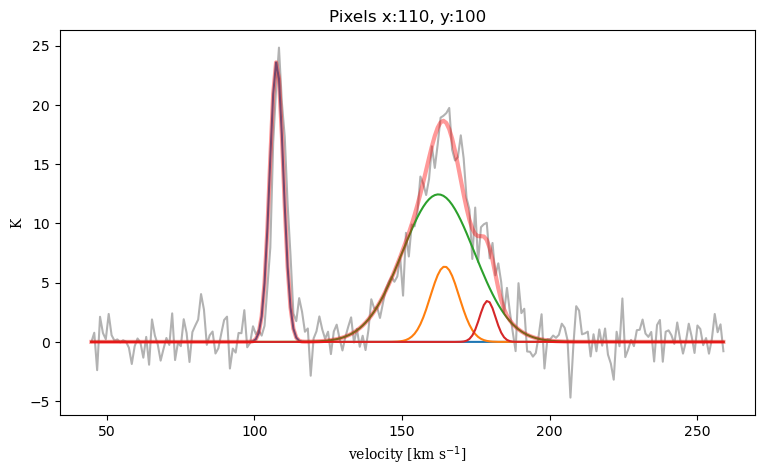

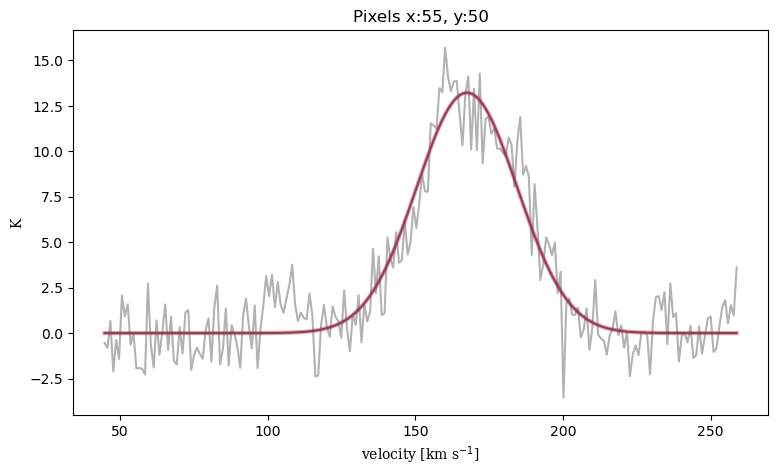

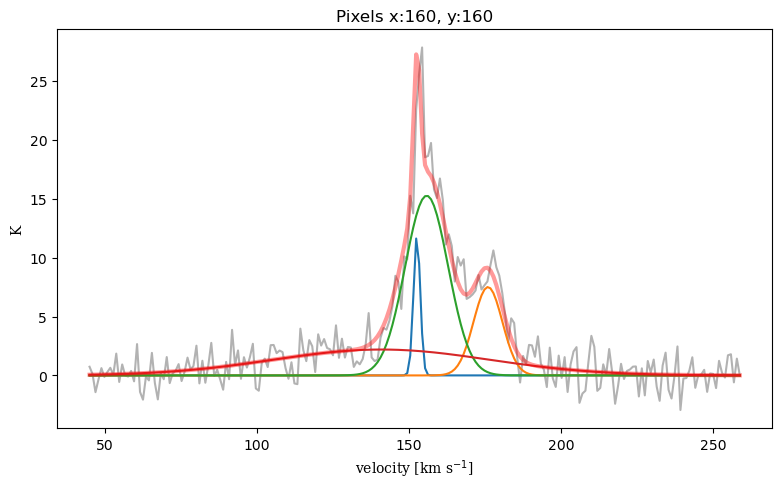

In [80]:
#make figure for first set of pixels

spectra1 = d[:,y_pix1,x_pix1]

# calculate the value for the first coordinate
s_start = h['CRVAL3'] - h['CRPIX3']*h['CDELT3']

# calculate the velocity axis
x_axis1 = (np.arange(0,len(spectra1))*h['CDELT3']+s_start) / 1000 # we also convert to km/s from m/s



fig = plt.figure(figsize=(30.5,5))
ax = fig.add_subplot(1,3,1)
plt.plot(x_axis1, spectra1, color='grey', alpha=0.6) 

for i in range(len(data_31)):
    model1 = models.Gaussian1D(amplitude=data_31['amp'][i], mean=data_31['VLSR'][i], stddev=data_31['vel_disp'][i])
    plt.plot(x_axis1, model1(x_axis1)) 
    
    if i == 0:
        model_all1 = model1
    else:
        model_all1 += model1 
    
plt.plot(x_axis1, model_all1(x_axis1), color = 'r', lw=3, alpha = 0.4)

ax.set_xlabel('velocity [km s$^{-1}$]', size=10,family='serif')
ax.set_ylabel('K', size=10,family='serif')
ax.set_title('Pixels x:110, y:100')

#make figure second set

spectra2 = d[:,y_pix2,x_pix2]

# calculate the value for the first coordinate
s_start = h['CRVAL3'] - h['CRPIX3']*h['CDELT3']

# calculate the velocity axis
x_axis2 = (np.arange(0,len(spectra2))*h['CDELT3']+s_start) / 1000 # we also convert to km/s from m/s



fig = plt.figure(figsize=(30.5,5))
ax = fig.add_subplot(1,3,2)
plt.plot(x_axis2, spectra2, color='grey', alpha=0.6) 

for i in range(len(data_32)):
    model2 = models.Gaussian1D(amplitude=data_32['amp'][i], mean=data_32['VLSR'][i], stddev=data_32['vel_disp'][i])
    plt.plot(x_axis2, model2(x_axis2)) 
    
    if i == 0:
        model_all2 = model2
    else:
        model_all2 += model2 
    
plt.plot(x_axis2, model_all2(x_axis2), color = 'r', lw=3, alpha = 0.4)

ax.set_xlabel('velocity [km s$^{-1}$]', size=10,family='serif')
ax.set_ylabel('K', size=10,family='serif')
ax.set_title('Pixels x:55, y:50')

#make figure third set

spectra3 = d[:,y_pix3,x_pix3]

# calculate the value for the first coordinate
s_start = h['CRVAL3'] - h['CRPIX3']*h['CDELT3']

# calculate the velocity axis
x_axis3 = (np.arange(0,len(spectra3))*h['CDELT3']+s_start) / 1000 # we also convert to km/s from m/s



fig = plt.figure(figsize=(23,5))
ax = fig.add_subplot(1,3,3)
plt.plot(x_axis3, spectra3, color='grey', alpha=0.6) 

for i in range(len(data_33)):
    model3 = models.Gaussian1D(amplitude=data_33['amp'][i], mean=data_33['VLSR'][i], stddev=data_33['vel_disp'][i])
    plt.plot(x_axis3, model3(x_axis3)) 
    
    if i == 0:
        model_all3 = model3
    else:
        model_all3 += model3 
    
plt.plot(x_axis3, model_all3(x_axis3), color = 'r', lw=3, alpha = 0.4)

ax.set_xlabel('velocity [km s$^{-1}$]', size=10,family='serif')
ax.set_ylabel('K', size=10,family='serif')
ax.set_title('Pixels x:160, y:160')


plt.tight_layout()
plt.show()

Does the spectra show the same features at these 3 different positions?

No, because there is a change in each plot.